In [98]:
%%javascript
function toggler(){
    if(window.already_toggling){  return 0 }
    let btn = $('.input').append('<button>Toggle</button>').children('button');
    btn.on('click', function(e){ let tgt = e.currentTarget;
        $(tgt).parent().children('.inner_cell').toggle() })
    window.already_toggling = true;}
setTimeout(toggler, 2000);

<IPython.core.display.Javascript object>

In [ ]:
# build folders for statistics (add # of MO's) and for plot output, automate plot generation 

# add sources

# FIXED THE DANG ENTROPY, Check Cv, Lm, Em, K, etc -> Empirical factor based off changed Em

# Read Me
Orignial files 'Model_sigma.txt', 'coef.txt', 'parameter.txt', 'rho_u_S1100.dat', and 'rho_u_S1100.dat' downloaded from https://github.com/mikinakajima/MeltScalingLaw (2-24-2021). Descriptions can be found in 'melt_model.py'. \
Accretion Model adapted from 'melt_model.py' and can be found in 'MeltModelJupyter.py'.\
For more information, see https://doi.org/10.1016/j.epsl.2021.116983.

# Accretion Model
Impacts from Mercury 6.2 are run through melt model.\
Velocities > 1.1, large gamma, or large impact angles may cause inconsistencies e.g., radius decreases between impacts.\
Melts are cooled with scheme from Nikolau 2019.\
If temperature is still hot, the entropy is updated before next impact.

## Accretion.py

In [1]:
from MeltModelJupyter import Model
import os
import numpy as np
from scipy.interpolate import interp1d

Settings = [line.strip() for line in open('Acc_Settings.txt')] # Defualts commented below
SimInput = len(os.listdir(Settings[2]))
SavingData = int(Settings[4]) # 1
Compressed = int(Settings[6]) # 1
stepSize = int(Settings[8]) # 365*25
RunSteamModel = int(Settings[12]) # 1
InitMolten = int(Settings[14]) # 0
InitH2O = int(Settings[16]) # 410
InitEnt = int(Settings[18]) # 1100
Insolation = int(Settings[20]) # 1
Lm = float(Settings[22]) # 7.18e5
Cv = int(Settings[24]) # 1000
Koliv = float(Settings[26]) # 0.007 

F_const = 340*0.75*(1-.76)*Insolation # venus like atm, young sun (Limaye et al 2018; DOI:10.1007/s11214-018-0525-2)
F_Solar = 340*0.75*(1-.275)*Insolation # 15-40% albedo for cloudless steam atm
Init_Mass = float([line for line in open('Init_du.dat')][1])
Init_du = [[float(y) for y in x] for x in [line.strip().split(' ') for line in open('Init_du.dat')][3:]]
F_bar = [float(x) for x in [line for line in open('F_bar.dat')][1].split(',')[:-1]] # ~285 w/m2 upper limit
barF = interp1d(np.arange(len(F_bar)), F_bar) #turning log fit into a continuous function -> useful for pressure < 25 bar
dt = (24*3600) # Epoch in days, F in seconds; F*dt*stepSize = 1 cooling step
UpCoolLim = 365*100000000 # years - 100my upperbound

print('Running Accretion Model with',RunSteamModel*(str(InitH2O)+' ppm H2O,')+(1-RunSteamModel)*'constant atmosphere,',Insolation*'solar insolation,',InitMolten*'and initially molten'+(1-InitMolten)*('and '+str(InitEnt)+' initial entropy'),'\n')
for sim in np.arange(1,SimInput+1):
    print('sim',sim,'\nImpact: ',end='')
# ------------ # data parsing and init - JimaInputs -> ['Name', ' Epoch', ' Angle', ' Mtotal', ' Impact_velocity', ' Gamma']
    data = np.array([[float(q) for q in x] for x in [(z[0].split(', ')[1:6]) for z in [x.split('\n') for x in open('Nakajima_Inputs/AccSim'+str(sim))][1:]]])
    JIsorted=data[data[:,0].argsort()] #sorted by impact date
    if(InitMolten): JIsorted = np.insert(JIsorted,0,[1,0,Init_Mass,1.2,0.5]).reshape(-1,5); InitEnt = 3160
        
# ------------ # Initialize arrays
    E_rem = np.zeros(2) # energy remaining in melt
    atmBuildup = np.zeros(int((JIsorted[-1][0]+UpCoolLim)/stepSize)) # atm only tracked in F_steam cooling model
    meltDSim = np.zeros([2,int((JIsorted[-1][0]+UpCoolLim)/stepSize)]) # depth for melt - Steam/Const cooling model
    mantleXw = np.ones(100)*InitH2O/1e6   # mantle water resovior vs depth - init water %wt 
    atmW = np.zeros(2) # Current atm, P saturation above magma (bar), mass Kg
    meltDStep = np.zeros(1) # Depth for current step - steam model

# ------------ # Running accretion model    
    entropy=InitEnt #start each simulation w/ initial value
    for k in np.arange(0,len(JIsorted)):
        print(k,end=' ',flush=True)
# ------------ # Melt model (Nakajima 2021, doi:10.1016/j.epsl.2021.116983)            
        m = Model(Mtotal=JIsorted[k][2], gamma=JIsorted[k][4], vel=max(1,JIsorted[k][3]), entropy0=entropy, impact_angle=JIsorted[k][1]); resp = m.run_model()

# ------------ # Melt Model variables are from core to surface, reveresed here for ease of use, other useful variables
        rr = m.rr[::-1]; dr = rr[0] - rr[1] # normed radius to 1 and incremental radius    
        Vplanet = 4/3*np.pi*m.radiusPlanet**3 # volume planet in m^3
        surfaceArea = 4*np.pi*m.radiusPlanet**2 # meters square
        V = [4/3*np.pi*(m.radiusPlanet**3*(rr[vol]**3-(rr[vol]-dr)**3)) for vol in np.arange(len(rr))] # volume of each radial section from surface to core
        MmeltTotal = (V*m.rho[::-1])  # mass melt at each depth surface to core
        
        rho = interp1d(np.linspace(0,1,30), m.rho[::-1]) ; r = (1-rr[-1])/100 # interpolation of density, finer resolution dr
        mv = np.zeros([100,2]) # mass, volume for different depths - finer resolution for mantle water
        for i in np.arange(100): 
            mv[i,1] = 4*np.pi/3*((m.radiusPlanet*(1-r*i))**3 - (m.radiusPlanet*(1-r*(i+1)))**3) # volume
            mv[i,0] = mv[i,1]*rho(i/100) # mass = V*density 
            
# ------------ # Finding Magma Ocean Depth using isostatic adjustment of melt Pool model
        Udiff = m.tmelt.T[0][::-1]/1e5 - (m.du-m.du_gain)[::-1,0] #energy diff from Init_du to melt T vs depth (*1e-5 J/Kg)
        warmingMag = 0; heatMelt = (Udiff*1e5+Lm)*MmeltTotal # energy to melt each layer U(J/kg) * V * density = joules       
        Ulayer = np.zeros(len(rr))
        for i in np.arange(len(Ulayer)): # all energy deposited from surface down
            Ulayer[i] = heatMelt[i]+warmingMag 
            if (i < 29): warmingMag = ((m.tmelt.T[0][::-1][i+1]-m.tmelt.T[0][::-1][i])/1000 * np.sum(MmeltTotal[0:i]) * Cv) # Energy to warm all magma to new melt T - should use Cp? -> *1.3
        sumUlayer = np.array([sum(Ulayer[0:i]) for i in np.arange(len(Ulayer)+1)]) # summed from 0 to depth

        meltDStep = (m.DP_PoolOcnConv[1,0]*1000)/(dr*m.radiusPlanet) # initial depth
        isoMeltE = (meltDStep%1)*Ulayer[int(meltDStep)] + np.sum(Ulayer[0:int(meltDStep)]) # E calc from latent heat and melt T
        if(m.DP_PoolOcnConv[1,0] == 0):
            meltDStep = (m.DP_PoolOcnConv[2,0]*1000)/(dr*m.radiusPlanet)*0.44 # empirical factor averaging isoMelt/convMelt
            isoMeltE = (meltDStep%1)*Ulayer[int(meltDStep)] + np.sum(Ulayer[0:int(meltDStep)])
        
# ------------ # Cooling Time until next impact 
        epoch = int(JIsorted[k][0]/stepSize)  #epoch in data is days (86400s) -> stepsize 
        if k < len(JIsorted)-1: coolingTime = int(JIsorted[k+1][0]/stepSize) - epoch 
        else: coolingTime = int(UpCoolLim/stepSize)

# ------------ # Cooling model with constant atm
        if(not RunSteamModel):
            constMeltE = isoMeltE + E_rem[1]; constMeltStep = epoch # initial energy and tracking total steps
            while(constMeltE > 0):
                meltIndx = min(29,np.where(constMeltE > sumUlayer)[0][-1])
                layerCoolStep = int((constMeltE - sumUlayer[meltIndx])/(F_const*surfaceArea*dt*stepSize)) #steps to cool this layer of melt
                if(layerCoolStep+constMeltStep-epoch < coolingTime): #only use if enough time before next impact
                    layerCoolE = constMeltE-np.arange(0,layerCoolStep+1)*(F_const*surfaceArea*dt*stepSize) # array - energy after cooling for steps
                    meltDSim[1,constMeltStep:layerCoolStep+constMeltStep+1] = (1 - rr[meltIndx] + (layerCoolE - sum(Ulayer[0:meltIndx]))/Ulayer[meltIndx]*dr) * m.radiusPlanet # convert energy to depth
                    constMeltStep += layerCoolStep # track total steps 
                    constMeltE = layerCoolE[-1] # update energy
                    if (constMeltE < F_const*surfaceArea*dt*stepSize+sumUlayer[meltIndx]): constMeltE = max(0,constMeltE-F_const*surfaceArea*dt*stepSize) # prevents small number error
                    if (constMeltE == 0): E_rem[1] = 0
                else:
                    layerCoolStep = int(coolingTime - (constMeltStep - epoch))
                    layerCoolE = constMeltE-np.arange(0,layerCoolStep+1)*(F_const*surfaceArea*dt*stepSize) # array - energy after cooling for steps
                    meltDSim[1,constMeltStep:layerCoolStep+constMeltStep+1] = (1 - rr[meltIndx] + (layerCoolE - sum(Ulayer[0:meltIndx]))/Ulayer[meltIndx]*dr) * m.radiusPlanet # convert energy to depth
                    E_rem[1] = layerCoolE[-1]; constMeltE = 0   # remaining energy carries into next impact
            meltDSim[1,epoch:] = m.radiusPlanet*(1-rr[-1])*(meltDSim[1,epoch:]>m.radiusPlanet*(1-rr[-1]))+(meltDSim[1,epoch:]<m.radiusPlanet*(1-rr[-1]))*meltDSim[1,epoch:]

# ------------ # Initializing depth, water conc of melt, data arrays    
        if(RunSteamModel):
            d0 = min(29/30,meltDStep*dr/(1-rr[-1])) # fractional melt depth of mantle
            XwRoot = sum([mantleXw[i]*mv[i,0] for i in np.arange(int(d0*100))],mantleXw[int(d0*100)]*mv[int(d0*100),0]*(100*d0%1))/sum(mv[0:int(d0*100),0],mv[int(d0*100),0]*(100*d0%1)) # total water in melt (Xi*Mi/Mtotal) 

            isoMeltEStep = np.float64(isoMeltE + E_rem[0]) # Energy -> steam model + remaining energy from previous MO

            for i in np.arange(len(Ulayer)): # initialize depth
                if (isoMeltEStep >= sum(Ulayer[0:i])): 
                    meltDSim[0,epoch] = min((1 - rr[i] + (isoMeltEStep-sum(Ulayer[0:i]))/Ulayer[min(i,29)]*dr),1-rr[-1]) * m.radiusPlanet  
            atmBuildup[epoch] = atmW[0]

# ------------ # cooling step, E loss, and depth change
            for step in np.arange(1,max(2,coolingTime+1)):
                if(np.sum(isoMeltEStep) == 0): 
                    meltDSim[0,epoch+step:] = 0; atmBuildup[epoch+step:] = atmW[0]
                    break # break and fill depth with 0's if all energy is lost to cooling, atm stays constant

                isoMeltEStep = max(0, isoMeltEStep - (barF(min(atmW[0],299)) - F_Solar)*surfaceArea*dt*stepSize) # net radiation out  

                for i in np.arange(len(Ulayer)): # Heat magma, melt layer, convert energy to depth
                    if (isoMeltEStep >= sum(Ulayer[0:i])): 
                        meltDStep = min((1 - rr[i] + (isoMeltEStep-sum(Ulayer[0:i]))/Ulayer[min(i,29)]*dr),1-rr[-1]) * m.radiusPlanet  

# ------------ # calculations for water content and outgassing of steam
                #depth calcs
                d0 = min(29/30,meltDSim[0,epoch+step-1]/m.radiusPlanet/(1-rr[-1])) # fractional melt depth of mantle
                d1 = min(29/30,meltDStep/m.radiusPlanet/(1-rr[-1])) 

                # mass calcs 
                solidM = rho((d0+d1)/2)*4/3*np.pi*((m.radiusPlanet - meltDStep)**3 - (m.radiusPlanet - meltDSim[0,epoch+step-1])**3) # density * volume of solidified melt
                solidW = solidM * XwRoot*(0.01 + Koliv) # 1% of melt trapped in solid -> mass water in newly solidified chunk
                newMeltM = sum(mv[0:int(d1*100),0]) + (100*d1%1)*mv[int(d1*100),0]
                unMelted = max(0, (mv[int(d0*100),0] - (newMeltM - sum(mv[0:int(d0*100),0]))) - solidM) # total solid mass - cooled solid = never melted

                # Xwater calcs # Most of this comes from (Nikolaou et al., 2019)
                labileW = atmW[1] + sum([mantleXw[i]*mv[i,0] for i in np.arange(int(d0*100))]) + XwRoot*mv[int(d0*100),0]*(100*d0%1) #integrate water w/ depth + atm
                XwSolvr = np.roots(np.array([(surfaceArea / ((6.67430*10**-11)*(m.Mmar*m.Mtotal)/m.radiusPlanet**2))/(6.8e-8)**(1/.7), 0, 0, newMeltM, 0,0,0,0,0,0,solidW-labileW]))
                XwRoot = (XwSolvr.real[(abs(XwSolvr.imag)<1e-5)*(XwSolvr>0)][0])**7      # post cooling Xh20      

                # atm calcs
                atmW[0] = ((min(max(XwRoot,0), 1)/6.8e-8)**(1/.7))/1e5 # update psat and mass atm # (Caroll & Holloway 1994)
                atmW[1] = atmW[0]*1e5 * surfaceArea/((6.67430*10**-11)*(m.Mmar*m.Mtotal)/m.radiusPlanet**2) # Kg h2o in atmosphere if saturated

                # mantle water content
                mantleXw[0:np.int(d1*100)] = XwRoot # only fully melted chunks assigned melt Xw value
                mantleXw[np.int(d0*100)] = (unMelted*mantleXw[np.int(d0*100)] + min(1,(mv[int(d0),0] - unMelted)/(solidM+1))*solidW)/(1+unMelted + min(solidM,mv[int(d0),0] - unMelted)) # this mantle chunk has fraction Xw of unmelted + cooled melt
                if(int(d1*100) < int(d0*100)): 
                    mantleXw[np.int(d1*100)] = solidW/solidM # chunk only contains newly cooled solid and melt
                
                #saving resultant atm and melt depth
                atmBuildup[epoch+step] = atmW[0]
                meltDSim[0,epoch+step] = meltDStep       

# ------------ # updating remaining energy and entropy for mantle                
            E_rem[0] = isoMeltEStep #Energy for existing magma ocean (successive impacts only)
            if(np.sum(1-m.du_melt) > 0):
                EntSolid = np.sum(Vplanet*m.dv*(1-m.du_melt)*(m.du_gain.T*m.rho).T)*1e5/np.sum(Vplanet*(1-m.du_melt).T*m.dv.T*m.rho) #entropy of the unmelted mantle
                if(EntSolid > Init_du[:][min(10,int(m.Mtotal/Init_Mass*5-4))][-1]): Ent = 3160 
                else: Ent=1100+206*np.where(EntSolid < Init_du[:][min(10,int(m.Mtotal/Init_Mass*5-4))])[0][0]
            else: Ent=3160
            if(Ent>entropy and m.DP_PoolOcnConv[1,0]>0): entropy = Ent # update entropy if greater than Init_du.dat, conventional model will have no du gain
    
# ------------ # saving data to file
    print('\n')
    if(SavingData): # steam model, constant model, atmosphere
        if(RunSteamModel):
            modelString='_'+str(InitH2O)+'w'+InitMolten*'M'+Insolation*'S'+str(InitEnt)+'e'
            lastMO=np.max(np.nonzero(meltDSim[0]))+80000 # dont save extra 0's, 2 myr buffer
            if(Compressed): np.savez_compressed('coolData/sim_'+str(sim)+modelString,meltDSim=meltDSim[0,:lastMO],atmBuildup=atmBuildup[:lastMO])
            elif(Compressed==False): np.savetxt('coolData/sim_'+str(sim)+modelString+'.txt',[meltDSim[0,:lastMO],atmBuildup[:lastMO]],'%.1f')
        elif(RunSteamModel==0):
            modelString='_const_'+InitMolten*'M'+Insolation*'S'+str(InitEnt)+'e'
            lastMO=np.max(np.nonzero(meltDSim[1]))+80000 # dont save extra 0's, 2 myr buffer
            if(Compressed): np.savez_compressed('coolData/sim_'+str(sim)+modelString,meltDSim=meltDSim[1,:lastMO],atmBuildup=atmBuildup[:lastMO])
            elif(Compressed==False): np.savetxt('coolData/sim_'+str(sim)+modelString+'.txt',[meltDSim[1,:lastMO],atmBuildup[:lastMO]],'%.1f')

Running Accretion Model with 820 ppm H2O, solar insolation, and initially molten 

sim 1 
Impact: 0 1 2 3 4 5 6 7 8 9 

KeyboardInterrupt: 

# Appendix
#### I.e. To be removed if it causes problems

## Sigma_Interp.py

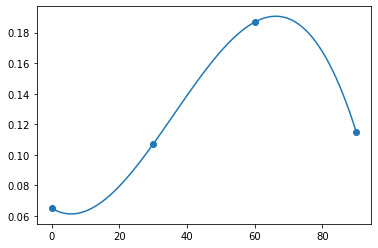

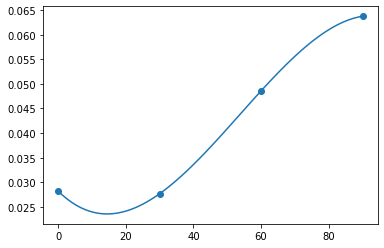

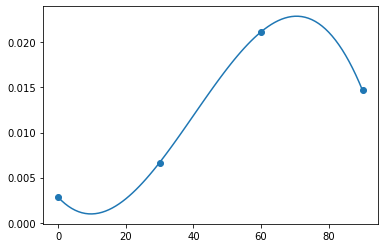

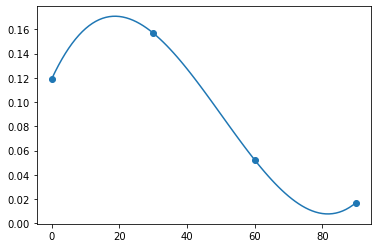

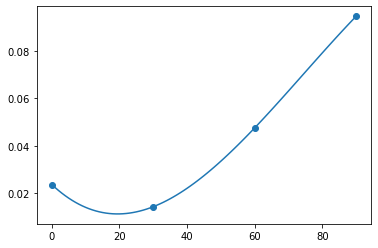

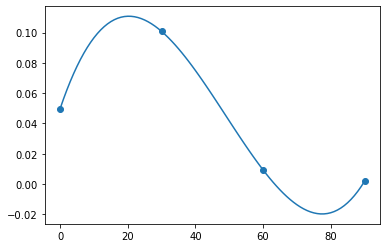

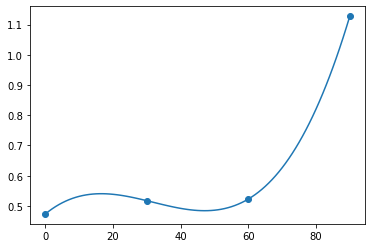

In [100]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

grid = np.arange(91) # can be made finer if needed
Angles = [0, 30, 60, 90] # default input options

# IE, vimp>vesc; # h model, vimp>vesc; # mantle model, vimp>vesc; # F model
sigma = [line.split() for line in open('Dependencies/Model_sigma.txt')] #data files may jave changed, double check from source
sigDat = np.zeros(shape=(7,4))
for sig in range(1, len(sigma)):
    sigDat[sig-1] = [float(i) for i in sigma[sig][0:4]]

# Polyfit model_sigma.txt data for interpolation
Y=np.zeros(shape=(len(sigDat),len(grid))) # Y holds the resulting interpolation
for j in np.arange(len(sigDat)):
    fit=np.polyfit(Angles,sigDat[j],3) # polynomial fit
    for i in np.arange(len(fit)):
        Y[j,:]+=fit[i]*grid**(len(fit)-i-1)

with open('Model_sigma_Grid.txt', 'w') as f: 
    print('# angle 0-90, first line is the DIE error and second is the F error', file=f)
    for q in np.arange(len(Y[0])):
        strings = ['%.8f' % number for number in Y.T[q][0:-1]]
        print(' '.join(strings),end=' ', file=f)
        print(f'{Y.T[q][-1]:.18f}', file=f)

Plotting == True
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    for j in np.arange(len(sigDat)):
        plt.figure(j)
        plt.scatter(Angles, sigDat[j])
        plt.plot(grid,Y[j])

## Rho_P_U_Interp.py

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

n=50 # of points for smoothed data

# ------------------------ # Reading S0=1100 data # ------------------------ #
rho_P = [line.split() for line in open('rho_u_S1100.dat')] #data files changed, add original to read from
rho_input = P_input = U_input = np.zeros(shape=(0,0))  # density, pressure, internal energy model
for m in range(1, len(rho_P)):  # data from rho_u_S1100.dat
    rho_input = np.append(rho_input, float(rho_P[m][0]))
    P_input = np.append(P_input, float(rho_P[m][1]) * 1e9)  # converting from GPa to Pa.
    U_input = np.append(U_input, float(rho_P[m][2]))   
    
# ------------------------ # Reading S0=3160 data # ------------------------ #
rho_P2 = [line.split() for line in open('rho_u_S3160.dat')]
rho_input2 = P_input2 = U_input2 = np.zeros(shape=(0,0))  # density, pressure, internal energy model
for m2 in range(1, len(rho_P2)):  # data from rho_u_S3160.dat
    rho_input2 = np.append(rho_input2, float(rho_P2[m2][0]))
    P_input2 = np.append(P_input2, float(rho_P2[m2][1]) * 1e9)  # converting from GPa to Pa.
    U_input2 = np.append(U_input2, float(rho_P2[m2][2]))

# ------------------------ # Interpolating U # ------------------------ #
rho_new=10**np.linspace(np.log10(rho_input[0]),np.log10(rho_input[-1]),n) # S0=1100 data 
yrP = interp1d(rho_input,P_input); P_new = yrP(rho_new)
yPU = interp1d(P_input,U_input); U_new = yPU(P_new)

rho_new2=10**np.linspace(np.log10(rho_input2[0]),np.log10(rho_input2[-1]),n) # S0=3160 data
yrP2 = interp1d(rho_input2,P_input2); P_new2 = yrP2(rho_new2)
yPU2 = interp1d(P_input2,U_input2); U_new2 = yPU2(P_new2)

TempInterp=11 #number of points to interpolate inclusive of boundaries
U_all=np.zeros(shape=(TempInterp,len(U_new)))
for i in np.arange(len(U_new)):
    U_all[:,i]=np.linspace((U_new[i]),(U_new2[i]),TempInterp) #linear spacing between data

# ------------------------ # Adjusting U from 88K-1187K to 300K-1900K # ------------------------ #
U_target = np.linspace(300,1900,11)*1000
U_fixed = U_all*np.linspace(1,(U_target/U_all[:,0]),50)[::-1].T**(.9**np.arange(50))

rho_u_data=np.append(rho_new,P_new/1e9)
rho_u_data=np.append(rho_u_data,U_fixed)

with open('rho_u_S9999.dat', 'w') as f:
    print('# rho (kg/m^3) P (GPa)     u: S=1100 J/kg/K  S= +206 J/kg/K', file=f)
    dat = rho_u_data.reshape(2+TempInterp,-1).T
    for s in np.arange(len(dat)):
        strings = ['%.8e' % number for number in dat[s]]
        print(' '.join(strings), file=f)

## Coef_Interp.py

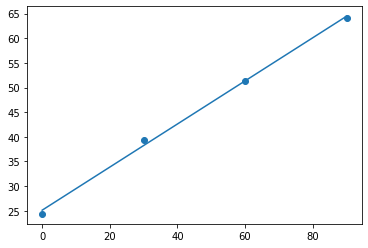

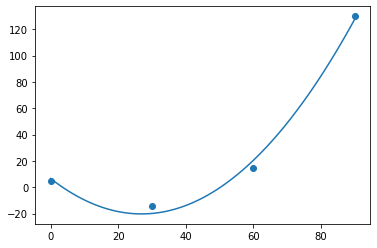

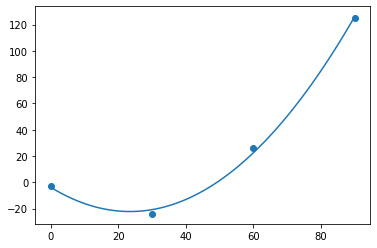

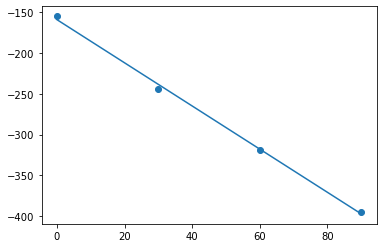

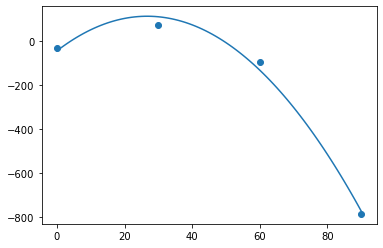

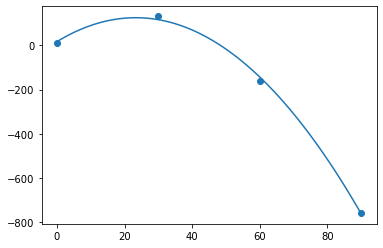

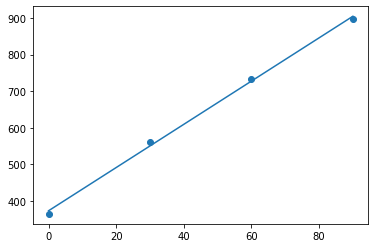

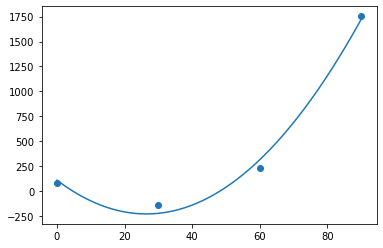

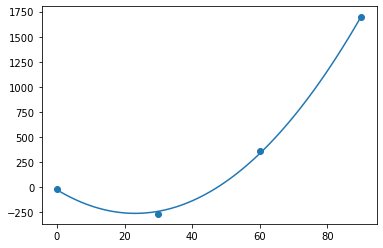

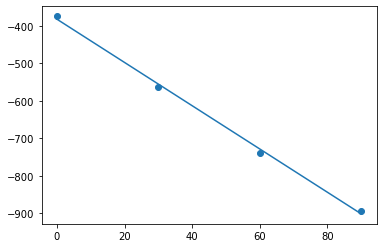

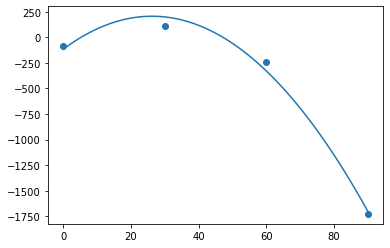

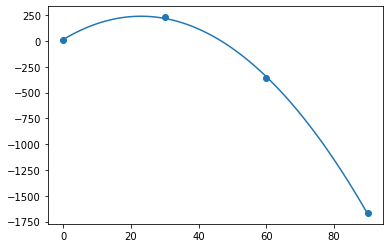

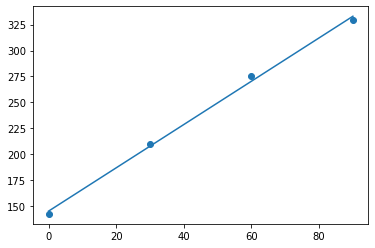

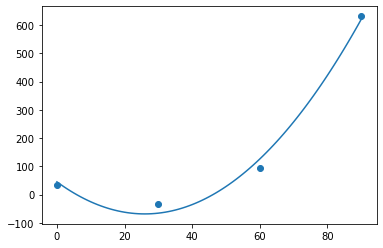

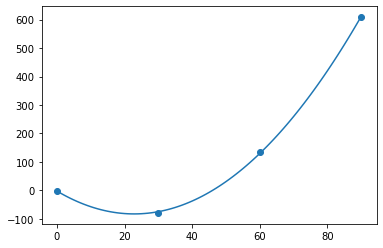

In [86]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

grid = np.arange(91) # can be made finer if needed
Angles = [0, 30, 60, 90] # default input options

# Reading coef.txt data - 4 angles 15 coef each # Check if values updated on github occasionally
coef = [line.split() for line in open('Dependencies/coef.txt')] 
coefDat = np.zeros(shape=(4,15))
for c in range(0, len(coef)):
    coefDat[c] = [float(i) for i in coef[c]]

# coef.txt interpolation
fitCoefExp = [1,2,2]
CoefGrid=np.zeros(shape=(15,91))
for k in np.arange(len(coefDat[0])):
    fitCoef = np.polyfit(Angles, [coefDat[0][k], coefDat[1][k], coefDat[2][k], coefDat[3][k]], fitCoefExp[k%3])
    YCoef=0
    for m in np.arange(len(fitCoef)):
        YCoef+=fitCoef[m]*grid**(len(fitCoef)-m-1)
    CoefGrid[k]=YCoef

with open('CoefGrid.txt', 'w') as f:
    for r in np.arange(len(CoefGrid[0])):
        strings = ['%.8f' % number for number in CoefGrid.T[r]]
        print(' '.join(strings), file=f)

Plotting = True
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    for k in np.arange(len(coefDat[0])):
        plt.figure(k)
        plt.scatter(Angles, [coefDat[0][k], coefDat[1][k], coefDat[2][k], coefDat[3][k]])
        plt.plot(grid,CoefGrid[k])

## BarF_Interp.py

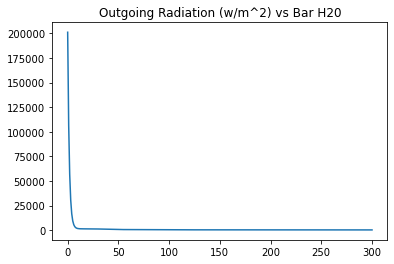

In [78]:
import numpy as np
np.set_printoptions(threshold=4000, linewidth=4000)

barA = np.array([0, 4, 25, 50, 100, 200, 300]) # input pressures and corresponding outgoing longwave radiation below
OLRA = np.array([200000, 16700, 1360, 670, 400, 300, 285]) # 900k -> black body; 200k -> trace volatiles e.g. silicon vapor
barGrid = np.arange(barA[0],barA[-1]+1)

OLRFit = np.polyfit(barA[0:3], 3.7*np.log10(OLRA[0:3])-13, 1); # log fit for first 3 data points
OLRGrid = np.array(10**(OLRFit[0]*barGrid[0:(barA[2]+1)]+OLRFit[1])+OLRA[2])

for p in np.arange(len(barA[2:])-1): # Appending linear interpolation for points 3 to 7
    thisGrid = np.arange(barGrid[barA[2+p]],barGrid[barA[3+p]]+1)
    s,b = np.polyfit((thisGrid[0],thisGrid[-1]), (OLRA[2+p], OLRA[2+p+1]), 1)
    OLRGrid = np.append(OLRGrid, s*thisGrid[1:]+b)
    
with open('F_bar.dat', 'w') as f:
    print('OLR w/m^2 per bar (0-300)',file=f)
    [print(round(OLRGrid[x],3),end=',',file=f) for x in barGrid]

Plotting = True
if(Plotting):
    import matplotlib.pyplot as plt
    plt.close('all')
    plt.figure('OLR vs Bar')
    plt.title('Outgoing Radiation (w/m^2) vs Bar H20')
    plt.plot(barGrid,OLRGrid)

## Init_Du.py

In [181]:
from MeltModelJupyter import Model
import numpy as np

# Calculating initial du for different mass/entropy combinations
Init_du = np.zeros(shape=(11,11))
massT = np.zeros(shape=(11))
Init_Mass = 3.1023287

for mass in np.arange(11):
    print('Mass:', Init_Mass*(1+mass/5), '\nEntropy:',end=' ')
    for ent in np.arange(11):
        print(ent*206+1100,end=' ',flush=True)
        initM = Model(Mtotal=Init_Mass*(1+mass/5), gamma=1e-9, vel=1.0, entropy0=(1100+206*ent), impact_angle=90); initRun=initM.run_model()
        mantM = np.sum(initM.radiusPlanet**3*initM.dv.T*initM.rho) # mass of mantle from density * volume *
        Init_du[ent][mass] = np.sum(initM.radiusPlanet**3*initM.dv*(initM.du.T*initM.rho).T)*1e5/mantM
    print('\n')

with open ('Init_du.dat','w') as f:
    print('Init_Mass\n',str(Init_Mass),'\nInit_du # [Ent][Mass]',file=f)
    [[print(round(y,2), end=' ',file=f) for y in x] and print('',file=f) for x in Init_du]

Mass: 3.1023287 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 3.72279444 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 4.34326018 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 4.963725920000001 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 5.58419166 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 6.2046574 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 6.8251231400000005 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 7.44558888 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 8.066054620000001 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 8.68652036 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass: 9.3069861 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 



## Build.py

In [2]:
import os
Dep=os.listdir('Dependencies/')
for i in Dep:
    with open(i,'w') as f:
        [print(line,end='',file=f) for line in open('Dependencies/'+i)]
    
import BarF_Interp, Coef_Interp, Sigma_Interp, Rho_P_U_Interp
isBuilt=True
for i in ['CoefGrid.txt','Model_sigma_Grid.txt','F_bar.dat','rho_u_S9999.dat']:
    if not os.path.exists(i): isBuilt=False
if isBuilt: import Init_Du

for i in Dep:
    if (os.path.exists(i) and (not i=='parameter.txt')): os.remove(i)

if not os.path.exists('coolData'): os.makedirs('coolData') 

Mass:  3.1023287 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  3.72279444 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  4.34326018 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  4.963725920000001 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  5.58419166 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  6.2046574 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  6.8251231400000005 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  7.44558888 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  8.066054620000001 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  8.68652036 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 

Mass:  9.3069861 
Entropy: 1100 1306 1512 1718 1924 2130 2336 2542 2748 2954 3160 



## Clean

In [2]:
# clears generated files and output
import os 
for i in ['CoefGrid.txt','Model_sigma_Grid.txt','F_bar.dat','Init_du.dat','rho_u_S9999.dat','parameter.txt']:
    if os.path.exists(i): os.remove(i)
# x=[os.remove('coolData/'+i) for i in os.listdir('coolData/')] # clears ALL model outputs

### Example impact with interpolation

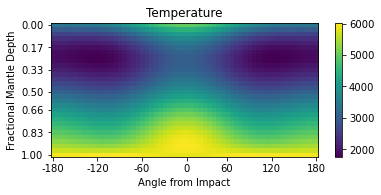

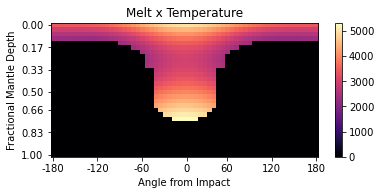

In [97]:
from MeltModelJupyter import Model
import matplotlib.pyplot as plt

m = Model(Mtotal=5, gamma=0.04, vel=1.0, entropy0=1100, impact_angle=40) # m contains all melt model outputs 
resp = m.run_model() #m.du=Temp/100, m.du_gain=deltaT/100, m.du_melt=molten, m.du_gain_melt=molten if T=solidus

plt.close('all')
plt.figure('Temperature')
plt.title('Temperature')
plt.set_cmap('viridis')
plt.xticks([0,10,20,30,39,49,59],np.arange(-180,240,60))
plt.yticks([0,5,10,15,19,24,29],['0.00','0.17','0.33','0.50','0.66','0.83','1.00'])
plt.xlabel('Angle from Impact')
plt.ylabel('Fractional Mantle Depth')
plt.imshow(m.du[::-1]*100)
plt.colorbar(shrink=0.615)

plt.figure('Melt')
plt.title('Melt x Temperature')
plt.set_cmap('magma')
plt.xticks([0,10,20,30,39,49,59],np.arange(-180,240,60))
plt.yticks([0,5,10,15,19,24,29],['0.00','0.17','0.33','0.50','0.66','0.83','1.00'])
plt.xlabel('Angle from Impact')
plt.ylabel('Fractional Mantle Depth')
plt.imshow(m.du[::-1]*100*m.du_melt[::-1]) # Temperature plot
plt.colorbar(shrink=0.615)
# plt.savefig('MeltxTemperatureExample.jpg',dpi=800)

# Plotting and Statistics

### Gamma threshold and Giant Impacts

In [72]:
GIGamma=0.03
AvgGIGamma=0
AllGamma=np.empty(0)
for sim in np.arange(1,21):
    data = np.array([[float(q) for q in x] for x in [(z[0].split(', ')[1:6]) for z in [x.split('\n') for x in open('Nakajima_Inputs/AccSim'+str(sim))][1:]]])
    AllGamma=np.append(AllGamma,data[:,-1])
    AvgGIGamma += sum(data[:,-1]>GIGamma)
print('Total Impacts:', len(AllGamma),'| Average Gamma:',round(np.average(AllGamma),6),'| GI Gamma Threshold:',GIGamma,'| Total GI:',AvgGIGamma,'| % of Impacts:',round(AvgGIGamma/(len(AllGamma)/100),2),'| Avg/sim:',AvgGIGamma/20)

Total Impacts: 830 | Average Gamma: 0.012305 | GI Gamma Threshold: 0.03 | Total GI: 60 | % of Impacts: 7.23 | Avg/sim: 3.0
